In [1]:
!python --version

Python 3.8.3


In [41]:
#install necessary packages

#pip install pandas matplotlib cartopy
#!pip install mplleaflet
#pip install pandas folium geopandas
#pip install --upgrade folium

In [44]:
#import required libraries

%matplotlib inline
import os
from datetime import datetime

# set environment variable needed for basemap

os.environ["PROJ_LIB"] = r'/opt/conda/pkgs/proj4-5.2.0-he1b5a44_1006/share/proj/'

import numpy as np
import mpl_toolkits

import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
from shapely.geometry import shape

import mapclassify
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#from mpl_toolkits.basemap import Basemap

import cartopy.crs as ccrs # import projection
import cartopy.feature as cf # import features

import json
import folium
import mplleaflet
import requests

In [43]:
print(folium.__version__)

0.17.0


In [9]:
import os

# Get the current working directory
current_directory = os.getcwd()

print("Current Directory:", current_directory)

Current Directory: /home/jovyan/work/GGIS 407/Course Project


## GGIS 407 Final Course Project: Urban Heat Island
### By: Nathan Makowski

--------------------------------------------------------------------------------------------------------------PART ONE--------------------------------------------------------------------------------------------------------------------------------------

In [52]:
# Loading the CSV data file with the appropriate encoding for readability
file_path = "/home/jovyan/work/GGIS 407/Course Project/Climate_Central_Urban_heat_islands_city_rankings___UHI_by_census_tract.csv"
data = pd.read_csv(file_path, encoding='ISO-8859-1')

#Checking the first few rows of the dataframe
print(data.head())

          City  Total population (2020 U.S. Census)   \
0     New York                            9,163,205    
1      Houston                            5,820,645    
2  Los Angeles                            7,195,330    
3       Dallas                            2,952,414    
4      Chicago                            4,002,922    

   Population in census tracts with >8° F urban heat island effect   \
0                                         7,124,781                   
1                                         4,254,195                   
2                                         3,271,985                   
3                                         2,199,962                   
4                                         2,098,100                   

  Percentage of population in census tracts with >8° F urban heat island effect  \
0                                             77.75%                              
1                                             73.09%                  

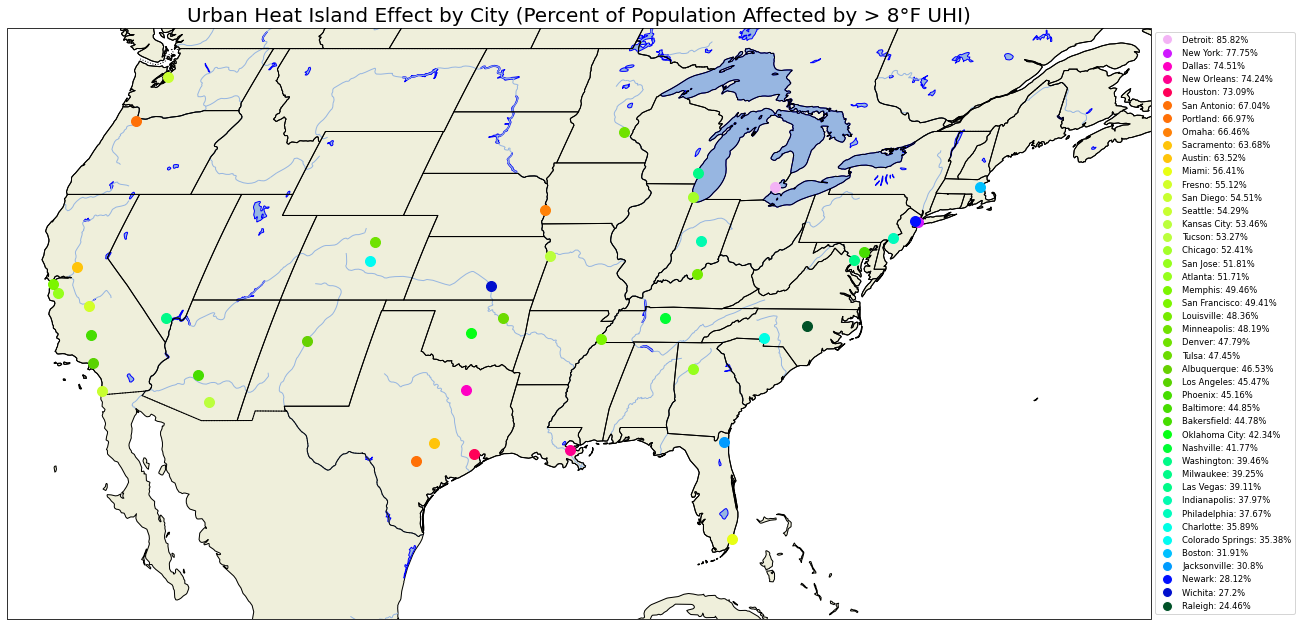

In [5]:
# Convert the percentage column in csv file to numeric
data['Percentage of population in census tracts with >8° F urban heat island effect'] = pd.to_numeric(
    data['Percentage of population in census tracts with >8° F urban heat island effect'].str.replace('%', '').str.strip(),
    errors='coerce'
)

# Coordinates for each city
coordinates = {
    'New York': (40.7128, -74.0060),
    'Houston': (29.7604, -95.3698),
    'Los Angeles': (34.0522, -118.2437),
    'Dallas': (32.7767, -96.7970),
    'Chicago': (41.8781, -87.6298),
    'San Antonio': (29.4241, -98.4936),
    'San Diego': (32.7157, -117.1611),
    'Phoenix': (33.4484, -112.0740),
    'Detroit': (42.3314, -83.0458),
    'Austin': (30.2672, -97.7431),
    'Philadelphia': (39.9526, -75.1652),
    'Denver': (39.7392, -104.9903),
    'San Jose': (37.3382, -121.8863),
    'Portland': (45.5155, -122.6793),
    'Kansas City': (39.0997, -94.5786),
    'Sacramento': (38.5816, -121.4944),
    'Louisville': (38.2542, -85.7594),
    'Seattle': (47.6062, -122.3321),
    'Atlanta': (33.7490, -84.3880),
    'Miami': (25.7617, -80.1918),
    'San Francisco': (37.7749, -122.4194),
    'Oklahoma City': (35.4676, -97.5164),
    'Nashville': (36.1627, -86.7816),
    'Las Vegas': (36.1699, -115.1398),
    'Indianapolis': (39.7684, -86.1581),
    'Washington': (38.9072, -77.0369),
    'New Orleans': (29.9511, -90.0715),
    'Memphis': (35.1495, -90.0490),
    'Boston': (42.3601, -71.0589),
    'Charlotte': (35.2271, -80.8431),
    'Omaha': (41.2565, -95.9345),
    'Tucson': (32.2226, -110.9747),
    'Fresno': (36.7378, -119.7871),
    'Baltimore': (39.2904, -76.6122),
    'Jacksonville': (30.3322, -81.6557),
    'Milwaukee': (43.0389, -87.9065),
    'Tulsa': (36.1539, -95.9928),
    'Albuquerque': (35.0844, -106.6504),
    'Bakersfield': (35.3733, -119.0187),
    'Minneapolis': (44.9778, -93.2650),
    'Colorado Springs': (38.8339, -104.8214),
    'Raleigh': (35.7796, -78.6382),
    'Newark': (40.7357, -74.1724),
    'Wichita': (37.6872, -97.3301),
}

# Create a mapping for cities, their coordinates, and affected percentages
city_data = {}
for index, row in data.iterrows():
    city_name = row['City']
    percent = row['Percentage of population in census tracts with >8° F urban heat island effect']
    
    if city_name in coordinates:
        coords = coordinates[city_name]
        city_data[city_name] = {'coords': coords, 'percent': percent}

# Create the figure and axis with the Robinson projection
fig, ax = plt.subplots(figsize=(20.5, 14), subplot_kw={'projection': ccrs.Robinson()})

# Set the extent of the map
ax.set_extent([-119, -64, 22, 50], crs=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cf.LAND)
ax.add_feature(cf.BORDERS, linestyle=':')
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.LAKES, edgecolor='blue')
ax.add_feature(cf.RIVERS)
ax.add_feature(cf.STATES)  

# Create a color map based on percentage affected using gist_ncar
colors = plt.cm.gist_ncar(np.linspace(0, 1, 100))

# Set a fixed size for the markers
marker_size = 10  

# Sort cities by percentage affected
sorted_cities = sorted(city_data.items(), key=lambda x: x[1]['percent'], reverse=True)

# List to hold legend handles
legend_handles = []

# Plot each city
for city, info in sorted_cities:
    percent = info['percent']
    coords = info['coords']
    
    # Normalize percentage for color mapping
    norm_percent = (percent - 20) / (90 - 20) if 20 <= percent <= 90 else (0 if percent < 20 else 1)
    color_index = int(norm_percent * 99)  # Convert to index for color map
    color = colors[color_index]

    # Plot the city marker
    ax.plot(coords[1], coords[0], marker='o', color=color, markersize=marker_size, transform=ccrs.PlateCarree())

    # Create a custom legend entry
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=marker_size, label=f'{city}: {percent}%'))

# Add a custom legend sorted by percentage
ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

# Title and show map
plt.title('Urban Heat Island Effect by City (Percent of Population Affected by > 8\u00B0F UHI)', fontsize=20) #Per the California EPA, the UHI Index is a positive temperature differential over time 
plt.show()                                                                                                    #between between an urban census tract and nearby upwind rural reference points
                                                                                                              #at a height of two meters above ground level, where people experience heat.   

--------------------------------------------------------------------------------------------------------------PART TWO-------------------------------------------------------------------------------------------------------------------------------------

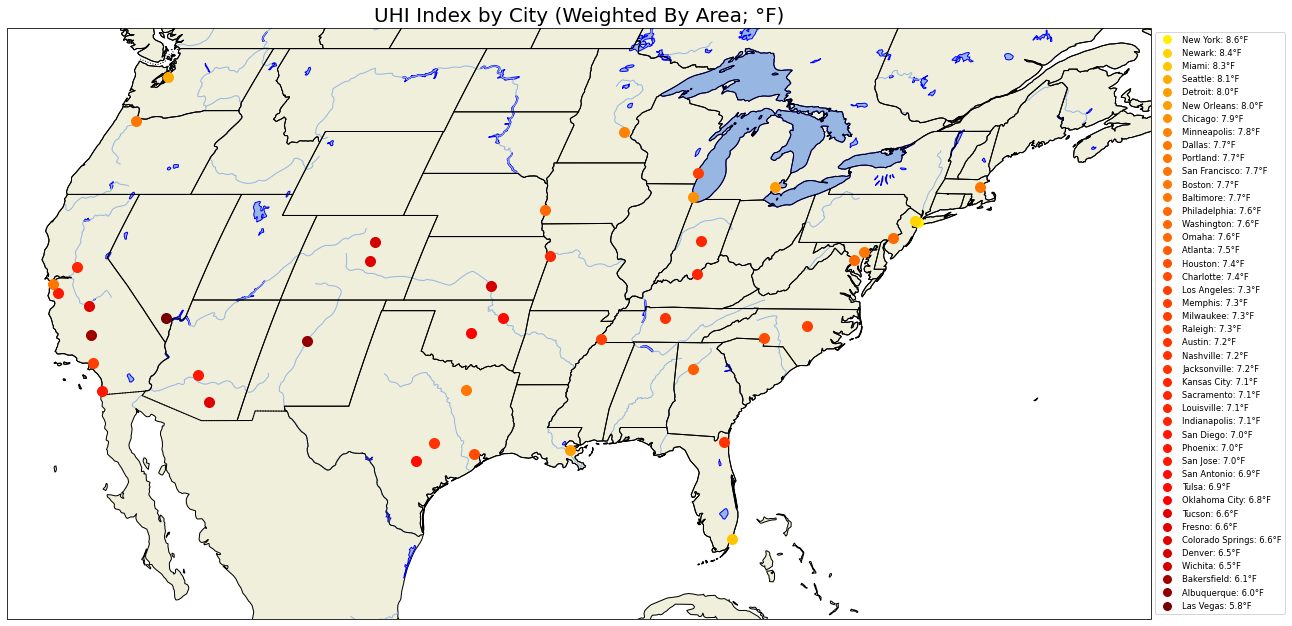

In [10]:
# Convert the UHI column in the CSV file to numeric
data['Citywide urban heat island effect (rolled-up from census tract data, weighted by area, in degrees F)'] = pd.to_numeric(
    data['Citywide urban heat island effect (rolled-up from census tract data, weighted by area, in degrees F)'], errors='coerce'
)

# Coordinates for each city
coordinates = {
    'New York': (40.7128, -74.0060),
    'Houston': (29.7604, -95.3698),
    'Los Angeles': (34.0522, -118.2437),
    'Dallas': (32.7767, -96.7970),
    'Chicago': (41.8781, -87.6298),
    'San Antonio': (29.4241, -98.4936),
    'San Diego': (32.7157, -117.1611),
    'Phoenix': (33.4484, -112.0740),
    'Detroit': (42.3314, -83.0458),
    'Austin': (30.2672, -97.7431),
    'Philadelphia': (39.9526, -75.1652),
    'Denver': (39.7392, -104.9903),
    'San Jose': (37.3382, -121.8863),
    'Portland': (45.5155, -122.6793),
    'Kansas City': (39.0997, -94.5786),
    'Sacramento': (38.5816, -121.4944),
    'Louisville': (38.2542, -85.7594),
    'Seattle': (47.6062, -122.3321),
    'Atlanta': (33.7490, -84.3880),
    'Miami': (25.7617, -80.1918),
    'San Francisco': (37.7749, -122.4194),
    'Oklahoma City': (35.4676, -97.5164),
    'Nashville': (36.1627, -86.7816),
    'Las Vegas': (36.1699, -115.1398),
    'Indianapolis': (39.7684, -86.1581),
    'Washington': (38.9072, -77.0369),
    'New Orleans': (29.9511, -90.0715),
    'Memphis': (35.1495, -90.0490),
    'Boston': (42.3601, -71.0589),
    'Charlotte': (35.2271, -80.8431),
    'Omaha': (41.2565, -95.9345),
    'Tucson': (32.2226, -110.9747),
    'Fresno': (36.7378, -119.7871),
    'Baltimore': (39.2904, -76.6122),
    'Jacksonville': (30.3322, -81.6557),
    'Milwaukee': (43.0389, -87.9065),
    'Tulsa': (36.1539, -95.9928),
    'Albuquerque': (35.0844, -106.6504),
    'Bakersfield': (35.3733, -119.0187),
    'Minneapolis': (44.9778, -93.2650),
    'Colorado Springs': (38.8339, -104.8214),
    'Raleigh': (35.7796, -78.6382),
    'Newark': (40.7357, -74.1724),
    'Wichita': (37.6872, -97.3301),
}

# Create a mapping for cities, their coordinates, and affected UHI indices
city_data = {}
for index, row in data.iterrows():
    city_name = row['City']
    if city_name in coordinates:
        city_data[city_name] = {
            'coords': coordinates[city_name],
            'uhi_index': row['Citywide urban heat island effect (rolled-up from census tract data, weighted by area, in degrees F)']
        }

# Create the figure and axis with the Robinson projection
fig, ax = plt.subplots(figsize=(20.5, 14), subplot_kw={'projection': ccrs.Robinson()})

# Set the extent of the map
ax.set_extent([-119, -64, 22, 50], crs=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cf.LAND)
ax.add_feature(cf.BORDERS, linestyle=':')
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.LAKES, edgecolor='blue')
ax.add_feature(cf.RIVERS)
ax.add_feature(cf.STATES) 

# Prepare data for plotting
for city, info in city_data.items():
    uhi_index = info['uhi_index']
    coords = info['coords']
    
    if pd.notna(uhi_index):  # Check if UHI index is valid
        # Normalize UHI index for color mapping
        norm_uhi = (uhi_index - 5) / (10 - 5)  # Adjust based on UHI range
        norm_uhi = min(max(norm_uhi, 0), 1)  # Clamp to [0, 1] range
        color = plt.cm.hot(norm_uhi)  # Use the hot colormap

#         Print the UHI index and coordinates for debugging
#        print(f'Plotting {city}: UHI Index = {uhi_index}, Coordinates = {coords}')

        # Plot the marker with transform
        ax.plot(coords[1], coords[0], marker='o', color=color, markersize=10, transform=ccrs.PlateCarree())  # Set marker size

# Create a custom legend based on UHI indices
handles = []
for city, info in city_data.items():
    uhi_index = info['uhi_index']
    if pd.notna(uhi_index):
        norm_uhi = (uhi_index - 5) / (10 - 5)
        norm_uhi = min(max(norm_uhi, 0), 1)
        color = plt.cm.hot(norm_uhi)
        handles.append((uhi_index, plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'{city}: {uhi_index}°F')))

# Sort handles by UHI Index in descending order
sorted_handles = sorted(handles, key=lambda x: x[0], reverse=True)

# Extract only the handles for the legend
legend_handles = [handle[1] for handle in sorted_handles]

# Add the legend to the plot
ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

# Title and show the map
plt.title('UHI Index by City (Weighted By Area; °F)', fontsize=20)
plt.show()

--------------------------------------------------------------------------------------------------------------PART THREE------------------------------------------------------------------------------------------------------------------------------------

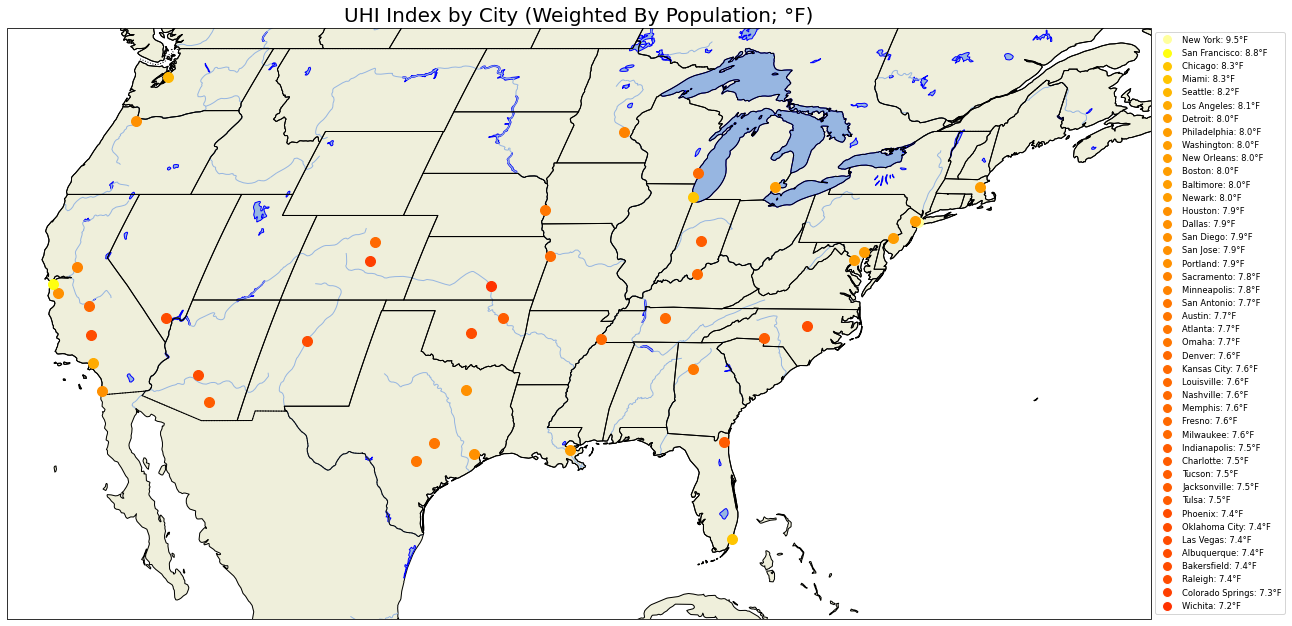

In [11]:
# Convert the UHI column in the CSV file to numeric
data['Citywide urban heat island effect (rolled-up from census tract data, weighted by population exposure, in degrees F)'] = pd.to_numeric(
    data['Citywide urban heat island effect (rolled-up from census tract data, weighted by population exposure, in degrees F)'], errors='coerce'
)

# Coordinates for each city
coordinates = {
    'New York': (40.7128, -74.0060),
    'Houston': (29.7604, -95.3698),
    'Los Angeles': (34.0522, -118.2437),
    'Dallas': (32.7767, -96.7970),
    'Chicago': (41.8781, -87.6298),
    'San Antonio': (29.4241, -98.4936),
    'San Diego': (32.7157, -117.1611),
    'Phoenix': (33.4484, -112.0740),
    'Detroit': (42.3314, -83.0458),
    'Austin': (30.2672, -97.7431),
    'Philadelphia': (39.9526, -75.1652),
    'Denver': (39.7392, -104.9903),
    'San Jose': (37.3382, -121.8863),
    'Portland': (45.5155, -122.6793),
    'Kansas City': (39.0997, -94.5786),
    'Sacramento': (38.5816, -121.4944),
    'Louisville': (38.2542, -85.7594),
    'Seattle': (47.6062, -122.3321),
    'Atlanta': (33.7490, -84.3880),
    'Miami': (25.7617, -80.1918),
    'San Francisco': (37.7749, -122.4194),
    'Oklahoma City': (35.4676, -97.5164),
    'Nashville': (36.1627, -86.7816),
    'Las Vegas': (36.1699, -115.1398),
    'Indianapolis': (39.7684, -86.1581),
    'Washington': (38.9072, -77.0369),
    'New Orleans': (29.9511, -90.0715),
    'Memphis': (35.1495, -90.0490),
    'Boston': (42.3601, -71.0589),
    'Charlotte': (35.2271, -80.8431),
    'Omaha': (41.2565, -95.9345),
    'Tucson': (32.2226, -110.9747),
    'Fresno': (36.7378, -119.7871),
    'Baltimore': (39.2904, -76.6122),
    'Jacksonville': (30.3322, -81.6557),
    'Milwaukee': (43.0389, -87.9065),
    'Tulsa': (36.1539, -95.9928),
    'Albuquerque': (35.0844, -106.6504),
    'Bakersfield': (35.3733, -119.0187),
    'Minneapolis': (44.9778, -93.2650),
    'Colorado Springs': (38.8339, -104.8214),
    'Raleigh': (35.7796, -78.6382),
    'Newark': (40.7357, -74.1724),
    'Wichita': (37.6872, -97.3301),
}

# Create a mapping for cities, their coordinates, and affected UHI indices
city_data = {}
for index, row in data.iterrows():
    city_name = row['City']
    if city_name in coordinates:
        city_data[city_name] = {
            'coords': coordinates[city_name],
            'uhi_index': row['Citywide urban heat island effect (rolled-up from census tract data, weighted by population exposure, in degrees F)']
        }

# Create the figure and axis with the Robinson projection
fig, ax = plt.subplots(figsize=(20.5, 14), subplot_kw={'projection': ccrs.Robinson()})

# Set the extent of the map
ax.set_extent([-119, -64, 22, 50], crs=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cf.LAND)
ax.add_feature(cf.BORDERS, linestyle=':')
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.LAKES, edgecolor='blue')
ax.add_feature(cf.RIVERS)
ax.add_feature(cf.STATES) 

# Prepare data for plotting
for city, info in city_data.items():
    uhi_index = info['uhi_index']
    coords = info['coords']
    
    if pd.notna(uhi_index):  # Check if UHI index is valid
        # Normalize UHI index for color mapping
        norm_uhi = (uhi_index - 5) / (10 - 5)  # Adjust based on UHI range
        norm_uhi = min(max(norm_uhi, 0), 1)  # Clamp to [0, 1] range
        color = plt.cm.hot(norm_uhi)  # Use the hot colormap

#         Print the UHI index and coordinates for debugging
#        print(f'Plotting {city}: UHI Index = {uhi_index}, Coordinates = {coords}')

        # Plot the marker with transform
        ax.plot(coords[1], coords[0], marker='o', color=color, markersize=10, transform=ccrs.PlateCarree())  # Set marker size

# Create a custom legend based on UHI indices
handles = []
for city, info in city_data.items():
    uhi_index = info['uhi_index']
    if pd.notna(uhi_index):
        norm_uhi = (uhi_index - 5) / (10 - 5)
        norm_uhi = min(max(norm_uhi, 0), 1)
        color = plt.cm.hot(norm_uhi)
        handles.append((uhi_index, plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'{city}: {uhi_index}°F')))

# Sort handles by UHI Index in descending order
sorted_handles = sorted(handles, key=lambda x: x[0], reverse=True)

# Extract only the handles for the legend
legend_handles = [handle[1] for handle in sorted_handles]

# Add the legend to the plot
ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

# Title and show the map
plt.title('UHI Index by City (Weighted By Population; °F)', fontsize=20)
plt.show()

--------------------------------------------------------------------------------------------------------------PART FOUR------------------------------------------------------------------------------------------------------------------------------------

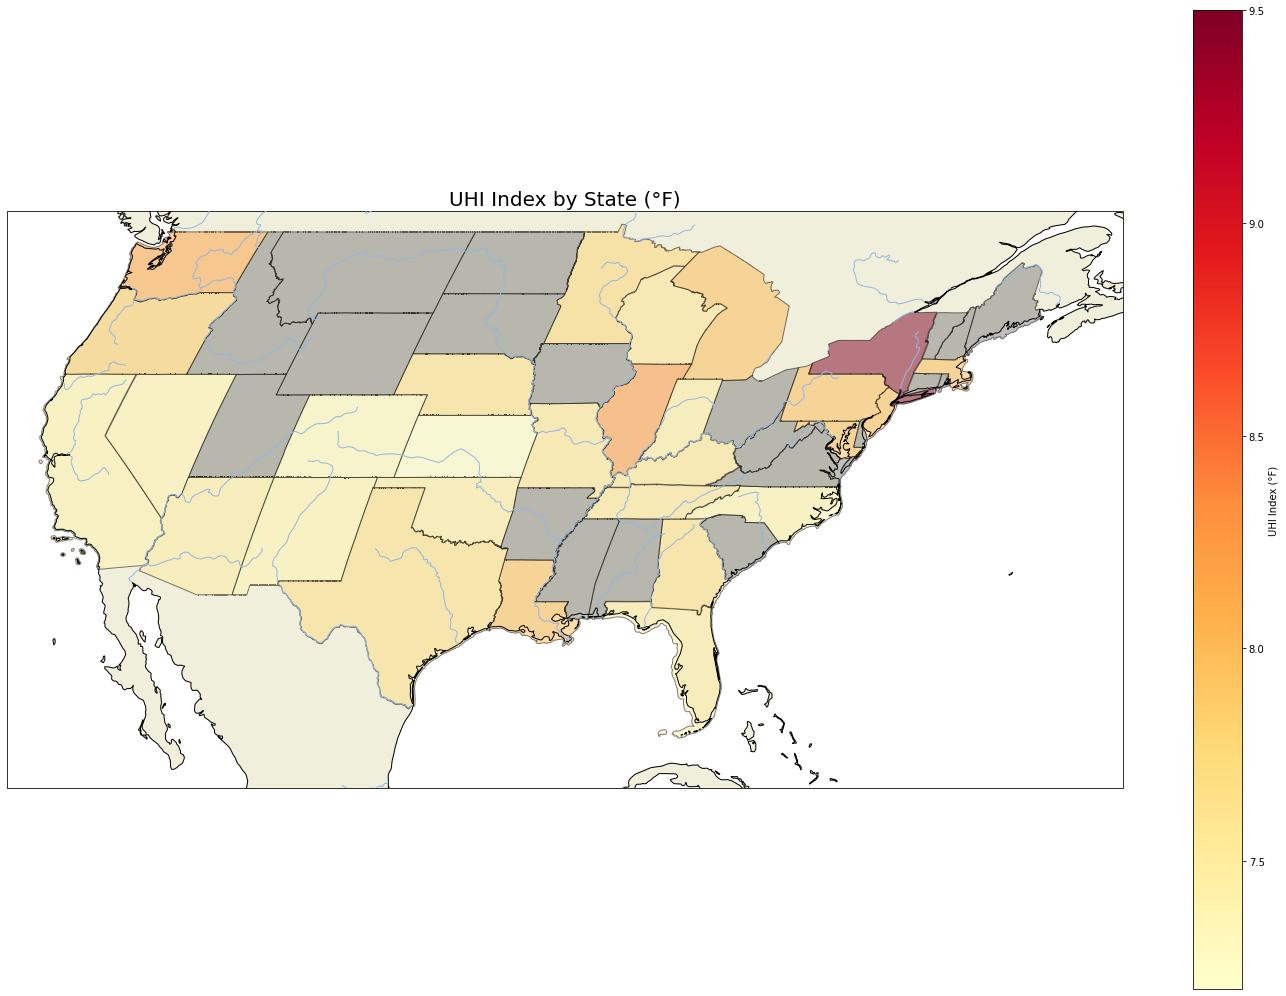

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader

# Convert the UHI column in the CSV file to numeric
data['Citywide urban heat island effect (rolled-up from census tract data, weighted by population exposure, in degrees F)'] = pd.to_numeric(
    data['Citywide urban heat island effect (rolled-up from census tract data, weighted by population exposure, in degrees F)'], errors='coerce'
)

# Coordinates for each city
coordinates = {
    'New York': (40.7128, -74.0060),
    'Houston': (29.7604, -95.3698),
    'Los Angeles': (34.0522, -118.2437),
    'Dallas': (32.7767, -96.7970),
    'Chicago': (41.8781, -87.6298),
    'San Antonio': (29.4241, -98.4936),
    'San Diego': (32.7157, -117.1611),
    'Phoenix': (33.4484, -112.0740),
    'Detroit': (42.3314, -83.0458),
    'Austin': (30.2672, -97.7431),
    'Philadelphia': (39.9526, -75.1652),
    'Denver': (39.7392, -104.9903),
    'San Jose': (37.3382, -121.8863),
    'Portland': (45.5155, -122.6793),
    'Kansas City': (39.0997, -94.5786),
    'Sacramento': (38.5816, -121.4944),
    'Louisville': (38.2542, -85.7594),
    'Seattle': (47.6062, -122.3321),
    'Atlanta': (33.7490, -84.3880),
    'Miami': (25.7617, -80.1918),
    'San Francisco': (37.7749, -122.4194),
    'Oklahoma City': (35.4676, -97.5164),
    'Nashville': (36.1627, -86.7816),
    'Las Vegas': (36.1699, -115.1398),
    'Indianapolis': (39.7684, -86.1581),
    'Washington': (38.9072, -77.0369),
    'New Orleans': (29.9511, -90.0715),
    'Memphis': (35.1495, -90.0490),
    'Boston': (42.3601, -71.0589),
    'Charlotte': (35.2271, -80.8431),
    'Omaha': (41.2565, -95.9345),
    'Tucson': (32.2226, -110.9747),
    'Fresno': (36.7378, -119.7871),
    'Baltimore': (39.2904, -76.6122),
    'Jacksonville': (30.3322, -81.6557),
    'Milwaukee': (43.0389, -87.9065),
    'Tulsa': (36.1539, -95.9928),
    'Albuquerque': (35.0844, -106.6504),
    'Bakersfield': (35.3733, -119.0187),
    'Minneapolis': (44.9778, -93.2650),
    'Colorado Springs': (38.8339, -104.8214),
    'Raleigh': (35.7796, -78.6382),
    'Newark': (40.7357, -74.1724),
    'Wichita': (37.6872, -97.3301),
}

# Function to get state from city
def get_state_from_city(city):
    state_mapping = {
        'New York': 'New York',
        'Houston': 'Texas',
        'Los Angeles': 'California',
        'Dallas': 'Texas',
        'Chicago': 'Illinois',
        'San Antonio': 'Texas',
        'San Diego': 'California',
        'Phoenix': 'Arizona',
        'Detroit': 'Michigan',
        'Austin': 'Texas',
        'Philadelphia': 'Pennsylvania',
        'Denver': 'Colorado',
        'San Jose': 'California',
        'Portland': 'Oregon',
        'Kansas City': 'Missouri',
        'Sacramento': 'California',
        'Louisville': 'Kentucky',
        'Seattle': 'Washington',
        'Atlanta': 'Georgia',
        'Miami': 'Florida',
        'San Francisco': 'California',
        'Oklahoma City': 'Oklahoma',
        'Nashville': 'Tennessee',
        'Las Vegas': 'Nevada',
        'Indianapolis': 'Indiana',
        'Washington': 'Washington, D.C.',
        'New Orleans': 'Louisiana',
        'Memphis': 'Tennessee',
        'Boston': 'Massachusetts',
        'Charlotte': 'North Carolina',
        'Omaha': 'Nebraska',
        'Tucson': 'Arizona',
        'Fresno': 'California',
        'Baltimore': 'Maryland',
        'Jacksonville': 'Florida',
        'Milwaukee': 'Wisconsin',
        'Tulsa': 'Oklahoma',
        'Albuquerque': 'New Mexico',
        'Bakersfield': 'California',
        'Minneapolis': 'Minnesota',
        'Colorado Springs': 'Colorado',
        'Raleigh': 'North Carolina',
        'Newark': 'New Jersey',
        'Wichita': 'Kansas',
    }
    return state_mapping.get(city, None)

# Load the shapefile for US states
shapefile_path = '/home/jovyan/work/GGIS 407/Course Project/tl_2024_us_state.shp'  
reader = shpreader.Reader(shapefile_path)

# Create a mapping for UHI indices
state_uhi_mapping = {}
for index, row in data.iterrows():
    city_name = row['City']
    uhi_index = row['Citywide urban heat island effect (rolled-up from census tract data, weighted by population exposure, in degrees F)']
    state_name = get_state_from_city(city_name)
    if state_name and pd.notna(uhi_index):
        state_uhi_mapping[state_name] = uhi_index

# Create the figure and axis with the Robinson projection
fig, ax = plt.subplots(figsize=(25, 18), subplot_kw={'projection': ccrs.Robinson()})
ax.set_extent([-119, -64, 22, 50], crs=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cf.LAND, zorder=1)
ax.add_feature(cf.COASTLINE, zorder=2)
ax.add_feature(cf.RIVERS, zorder=3)

# Prepare to shade states based on UHI values
uhi_values = list(state_uhi_mapping.values())
min_uhi = min(uhi_values)
max_uhi = max(uhi_values)

# Shade the states based on UHI values
for state in reader.records():
    state_name = state.attributes['NAME']  # Adjust based on your shapefile's attributes
    uhi_index = state_uhi_mapping.get(state_name)

    if pd.notna(uhi_index):  # Check if UHI index is valid
        # Normalize UHI index for color mapping
        norm_uhi = (uhi_index - min_uhi) / (max_uhi - min_uhi)  # Dynamic normalization
        norm_uhi = min(max(norm_uhi, 0), 1)  # Clamp to [0, 1] range
        color = plt.cm.YlOrRd(norm_uhi)  # Use the hot colormap

        # Shade the state using geometries
        ax.add_geometries([state.geometry], ccrs.PlateCarree(), 
                          facecolor=color, edgecolor='black', alpha=0.5)
    else:
        # Shade states without UHI data in grey
        ax.add_geometries([state.geometry], ccrs.PlateCarree(), 
                            facecolor='grey', edgecolor='black', alpha=0.5)
        
# Add a color bar
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=min_uhi, vmax=max_uhi))
sm._A = []  # Only needed for older versions of matplotlib
plt.colorbar(sm, ax=ax, orientation='vertical', label='UHI Index (°F)')

#Title and show the map
plt.title('UHI Index by State (°F)', fontsize=20)
plt.show()

--------------------------------------------------------------------------------------------------------------PART FIVE--------------------------------------------------------------------------------------------------------------------------------------

In [51]:
# Fetch the GeoJSON data from the URL
geo_json_data = requests.get(
    "https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json"
).json()

# Print a sample of the fetched GeoJSON data
print(geo_json_data['features'][:1])  # Print the first two features to check the structure
print("\n")

# State-level average monthly high temperature data for August 2024
state_temp = '/home/jovyan/work/GGIS 407/Course Project/august_avg_tempf.csv'

# Read the CSV file into a DataFrame
state_temp_df = pd.read_csv(state_temp)

# Print the first few rows of the DataFrame
print(state_temp_df.head(), "\n")

state_temp_df['state'] = state_temp_df['state'].str.strip().str.title()  # Adjust as needed

# Create a mapping from full state names to abbreviations if needed
state_abbrev_map = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY"
}

# Map the state names in the DataFrame to their abbreviations
state_temp_df['state'] = state_temp_df['state'].map(state_abbrev_map)

# Drop any rows where mapping resulted in NaN
state_temp_df.dropna(subset=['state'], inplace=True)

#Check number of NaN, if any => There were zero. 
#print(state_temp_df['state'].isna().sum())

# Create the dictionary again
state_temp_dict = state_temp_df.set_index("state")["August_avg_tempf"].to_dict()

# Verify the resulting dictionary
print(state_temp_dict, "\n")

# Initialize the Folium Map
m = folium.Map(location=[48, -102], zoom_start=3)

# Define the color function
def my_color_function(feature):
    """Maps temperatures to colors based on specified thresholds."""
    state_name = feature["id"]  # Use "id" for matching
    temp = state_temp_dict.get(state_name, 0)

    if temp >= 110:
        return "#ff0000"  # Dark red for temperatures >= 110
    elif temp >= 105:
        return "#ff3f00"  # Bright red for temperatures >= 105
    elif temp >= 100:
        return "#ff7f00"  # Orange for temperatures >= 100
    elif temp >= 95:
        return "#ffb300"  # Light orange for temperatures >= 95
    elif temp >= 90:
        return "#ffff00"  # Yellow for temperatures >= 90
    elif temp >= 85:
        return "#c0ff00"  # Light yellow-green for temperatures >= 85
    elif temp >= 80:
        return "#7fff00"  # Light green for temperatures >= 80
    elif temp >= 75:
        return "#00ff00"  # Green for temperatures >= 75
    elif temp >= 70:
        return "#00ffff"  # Cyan for temperatures >= 70
    elif temp >= 65:
        return "#007fff"  # Light blue for temperatures >= 65
    elif temp >= 60:
        return "#0000ff"  # Blue for temperatures >= 60
    else:
        return "#0000ff"  # Still blue for temperatures < 60

# Adding the GeoJson layer with the custom style
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        "fillColor": my_color_function(feature),
        "color": "black",
        "weight": 2,
        "dashArray": "5, 5",
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name"],  # "id" contains the state abbreviation
        aliases=["State:"],
        localize=True,
        sticky=True,
        labels=True,
        style="""
        background-color: white;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
        """,
        always_visible=True,  # Set to True to keep it visible
    )
).add_to(m)

# Adding a second tooltip for average temperature
for feature in geo_json_data['features']:
    state_name = feature['id']
    temp = state_temp_dict.get(state_name, None)
    
    if temp is not None:
        # Calculate the centroid of the feature
        geom = shape(feature['geometry'])
        centroid = geom.centroid
        tooltip_text = f"{feature['properties']['name']}: Average High Temperature: {temp}°F"  # Use the name here

        folium.Marker(
            location=[centroid.y, centroid.x],
            tooltip=tooltip_text,
            icon=None  # Customize icon if needed
        ).add_to(m)

# Define the legend HTML
legend_html = '''
<div style="position: fixed; 
             top: 10px; left: 10px; width: 160px; height: auto; 
             border:2px solid grey; background:white; 
             z-index:9999; font-size:14px; padding:10px;">
    <b>Temperature Legend</b><br>
    <i style="background: #ff0000; opacity: 0.7;"></i> &nbsp; ≥ 110°F<br>
    <i style="background: #ff3f00; opacity: 0.7;"></i> &nbsp; 105°F - 109°F<br>
    <i style="background: #ff7f00; opacity: 0.7;"></i> &nbsp; 100°F - 104°F<br>
    <i style="background: #ffb300; opacity: 0.7;"></i> &nbsp; 95°F - 99°F<br>
    <i style="background: #ffff00; opacity: 0.7;"></i> &nbsp; 90°F - 94°F<br>
    <i style="background: #c0ff00; opacity: 0.7;"></i> &nbsp; 85°F - 89°F<br>
    <i style="background: #7fff00; opacity: 0.7;"></i> &nbsp; 80°F - 84°F<br>
    <i style="background: #00ff00; opacity: 0.7;"></i> &nbsp; 75°F - 79°F<br>
    <i style="background: #00ffff; opacity: 0.7;"></i> &nbsp; 70°F - 74°F<br>
    <i style="background: #007fff; opacity: 0.7;"></i> &nbsp; 65°F - 69°F<br>
    <i style="background: #0000ff; opacity: 0.7;"></i> &nbsp; < 65°F<br>
</div>
'''        

# Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))        
        
# Display the map
m

[{'type': 'Feature', 'id': 'AL', 'properties': {'name': 'Alabama'}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-87.359296, 35.00118], [-85.606675, 34.984749], [-85.431413, 34.124869], [-85.184951, 32.859696], [-85.069935, 32.580372], [-84.960397, 32.421541], [-85.004212, 32.322956], [-84.889196, 32.262709], [-85.058981, 32.13674], [-85.053504, 32.01077], [-85.141136, 31.840985], [-85.042551, 31.539753], [-85.113751, 31.27686], [-85.004212, 31.003013], [-85.497137, 30.997536], [-87.600282, 30.997536], [-87.633143, 30.86609], [-87.408589, 30.674397], [-87.446927, 30.510088], [-87.37025, 30.427934], [-87.518128, 30.280057], [-87.655051, 30.247195], [-87.90699, 30.411504], [-87.934375, 30.657966], [-88.011052, 30.685351], [-88.10416, 30.499135], [-88.137022, 30.318396], [-88.394438, 30.367688], [-88.471115, 31.895754], [-88.241084, 33.796253], [-88.098683, 34.891641], [-88.202745, 34.995703], [-87.359296, 35.00118]]]}}]


         state  August_avg_tempf
0      Alabama              